**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### **Importing required Libraries and mounting drive**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
!cd /content/gdrive/MyDrive/AIML/ColabNotebooks/CNN

In [7]:
!unzip /content/gdrive/MyDrive/AIML/ColabNotebooks/CNN/CNN_Dataset/CNN_assignment_dataset.zip > /dev/null

The dataset has been imported into the google drive in below location.
/content/gdrive/MyDrive/AIML/ColabNotebooks/CNN/CNN_Dataset/

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [8]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [9]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### **Load using keras.preprocessing**

Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Create a dataset**

Define some parameters for the loader:

In [10]:
batch_size = 32
img_height = 180
img_width = 180

In [11]:
#Use 80% of the images for training, and 20% for validation.

In [12]:

## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure you resize your images to the size img_height*img_width, while writing the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [13]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [14]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [15]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [16]:
class_names = test_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### **Visualize the data**

Create a code to visualize one instance of all the nine classes present in the *dataset*

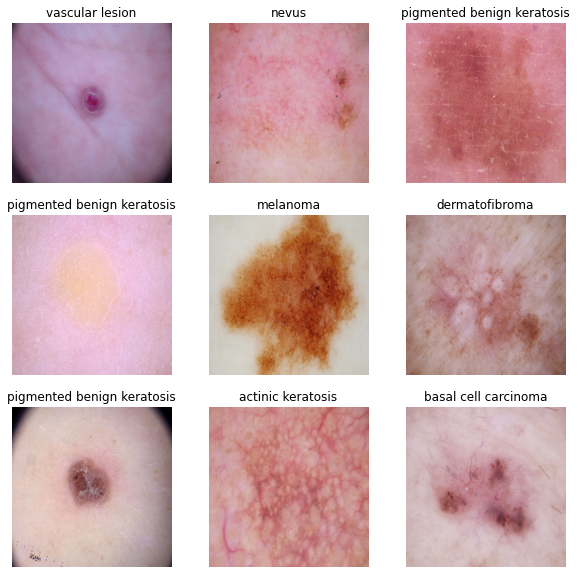

In [17]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
# Retrieving Image batch shape and labels batch shape
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### **Creating the model**

**Note**: We have previously resized images using the image_size argument of tf.keras.utils.image_dataset_from_directory. If we want to include the resizing logic in your model as well, we can use the tf.keras.layers.Resizing layer inside the model creation step.
So in that case the model creation step will have the following architecture.

Sequential([

    - resizing

    - rescaling

    - conv2d

    - MaxPool

    - conv2d

    - MaxPool

    - conv2d

    - MaxPool

    - Flatten

    - Dense

    - Dense
    
])

In [20]:
### Adding network architecture to model

model = Sequential([
            layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(len(class_names))
])

In [21]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
# View Summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### **Creating the model**

In [23]:
epochs = 20
model_results = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 25s 99ms/step - loss: 2.0275 - accuracy: 0.2277 - val_loss: 1.7822 - val_accuracy: 0.3602
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.6668 - accuracy: 0.3984 - val_loss: 1.5552 - val_accuracy: 0.4676
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.4709 - accuracy: 0.4916 - val_loss: 1.4591 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 2s 41ms/step - loss: 1.4043 - accuracy: 0.5151 - val_loss: 1.4778 - val_accuracy: 0.4899
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.3233 - accuracy: 0.5223 - val_loss: 1.3858 - val_accuracy: 0.5369
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.2544 - accuracy: 0.5508 - val_loss: 1.4553 - val_accuracy: 0.4966
Epoch 7/20
56/56 [==============================] - 2s 42ms/step - loss: 1.1722 - accuracy: 0.5926 - val_loss: 1.4130 - val_accuracy: 0.5459
Epoch 8/20
5

**Visualizing training results**

In [24]:
model_results.history

{'accuracy': [0.2276785671710968,
  0.3984375,
  0.4916294515132904,
  0.5150669813156128,
  0.5223214030265808,
  0.55078125,
  0.5926339030265808,
  0.6088169813156128,
  0.6227678656578064,
  0.6233258843421936,
  0.6752232313156128,
  0.6986607313156128,
  0.7282366156578064,
  0.7589285969734192,
  0.7728794813156128,
  0.7940848469734192,
  0.8113839030265808,
  0.8191964030265808,
  0.8353794813156128,
  0.8454241156578064],
 'loss': [2.0275354385375977,
  1.6668144464492798,
  1.4708877801895142,
  1.4043245315551758,
  1.3232519626617432,
  1.254425048828125,
  1.1721917390823364,
  1.0903058052062988,
  1.0431321859359741,
  0.9984489679336548,
  0.892802357673645,
  0.8266635537147522,
  0.7596478462219238,
  0.6838582754135132,
  0.6301234364509583,
  0.5681286454200745,
  0.48736950755119324,
  0.5044175386428833,
  0.464160293340683,
  0.4090407192707062],
 'val_accuracy': [0.36017897725105286,
  0.4675615131855011,
  0.5100671052932739,
  0.4899328947067261,
  0.53691273

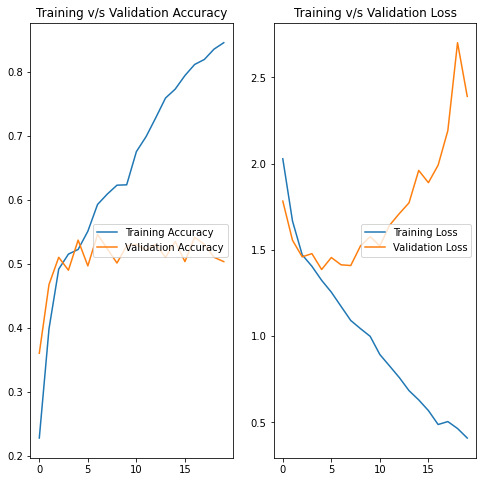

In [25]:
train_acc = model_results.history['accuracy']
val_acc = model_results.history['val_accuracy']

train_loss = model_results.history['loss']
val_loss = model_results.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))

# Visualizing training and validation accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Training v/s Validation Accuracy')

# Visualizing training and validation loss
plt.subplot(1,2,2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='center right')
plt.title('Training v/s Validation Loss')

plt.show()

**Analysis** : It is evident from the above graph that there is big difference between the Training and Validation Accuracy which suggest clear signs of overfitting. This could be due to low number of samples available for training.

Handling overfitting of the model using **data augmentation**

In [26]:
# Data Augmentation can be of different types. Here we will understand the effect of Data Augmentation applied on one of the images in the train data set.
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

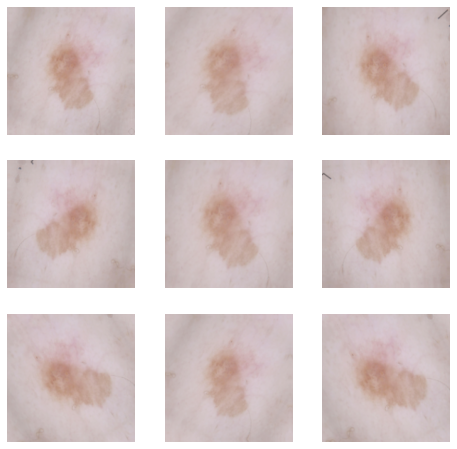

In [27]:
from numpy.lib.function_base import trapz
# Visualizing augmentation applied on one of the images.
plt.figure(figsize=(8,8))

for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis("off")


In [28]:
# Below data augmentation will be applied on the model during model creation
data_augmentation_sequential = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# Creating model using data augmentation and adding dropouts to reduce overfiting.
model = Sequential([
                    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    data_augmentation_sequential,
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Dropout(0.1),
                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Dropout(0.1),
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Dropout(0.1),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(len(class_names))
])

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

In [30]:
epochs = 20
model_dropouts_results = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/20
56/56 [==============================] - 4s 57ms/step - loss: 2.4173 - accuracy: 0.2015 - val_loss: 2.0197 - val_accuracy: 0.3132
Epoch 2/20
56/56 [==============================] - 3s 53ms/step - loss: 1.8700 - accuracy: 0.3253 - val_loss: 1.8029 - val_accuracy: 0.3848
Epoch 3/20
56/56 [==============================] - 3s 52ms/step - loss: 1.6551 - accuracy: 0.4096 - val_loss: 1.6362 - val_accuracy: 0.4385
Epoch 4/20
56/56 [==============================] - 3s 52ms/step - loss: 1.6072 - accuracy: 0.4219 - val_loss: 1.5797 - val_accuracy: 0.4631
Epoch 5/20
56/56 [==============================] - 3s 52ms/step - loss: 1.5519 - accuracy: 0.4397 - val_loss: 1.5484 - val_accuracy: 0.4519
Epoch 6/20
56/56 [==============================] - 3s 53ms/step - loss: 1.4899 - accuracy: 0.4671 - val_loss: 1.5678 - val_accuracy: 0.4765
Epoch 7/20
56/56 [==============================] - 3s 52ms/step - loss: 1.4606 - accuracy: 0.4766 - val_loss: 1.4795 - val_accuracy: 0.4832
Epoch 8/20
56

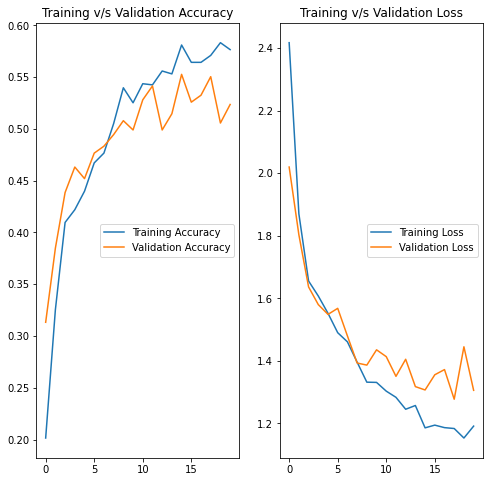

In [31]:
# Visualizing results where model includes augmentation and dropouts.
train_acc = model_dropouts_results.history['accuracy']
val_acc = model_dropouts_results.history['val_accuracy']

train_loss = model_dropouts_results.history['loss']
val_loss = model_dropouts_results.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))

# Visualizing training and validation accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Training v/s Validation Accuracy')

# Visualizing training and validation loss
plt.subplot(1,2,2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='center right')
plt.title('Training v/s Validation Loss')

plt.show()

**Analysis** : It is evident from the above graph that there is not much difference between the Training and Validation Accuracy which suggests a more generalized model. However, the accuracy of the model is not very high.

In [32]:
# Below data augmentation will be applied on the model during model creation. Choosing to build model USING AUGMENTATION WITHOUT DROPOUTS
data_augmentation_sequential = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

# Creating model using data augmentation and adding dropouts to reduce overfiting.
model_no_dropouts = Sequential([
                    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
                    data_augmentation_sequential,
                    layers.Conv2D(16, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(32, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Conv2D(64, 3, padding='same', activation='relu'),
                    layers.MaxPooling2D(),
                    layers.Flatten(),
                    layers.Dense(128, activation='relu'),
                    layers.Dense(len(class_names))
])

In [33]:
model_no_dropouts.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model_no_dropouts.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [34]:
epochs = 20
model_no_dropouts_results = model_no_dropouts.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/20
56/56 [==============================] - 4s 51ms/step - loss: 2.0322 - accuracy: 0.2388 - val_loss: 1.8499 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - 3s 48ms/step - loss: 1.6500 - accuracy: 0.4118 - val_loss: 1.5904 - val_accuracy: 0.4318
Epoch 3/20
56/56 [==============================] - 3s 47ms/step - loss: 1.5882 - accuracy: 0.4314 - val_loss: 1.4907 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 3s 48ms/step - loss: 1.4536 - accuracy: 0.4844 - val_loss: 1.4007 - val_accuracy: 0.5280
Epoch 5/20
56/56 [==============================] - 3s 48ms/step - loss: 1.3890 - accuracy: 0.5123 - val_loss: 1.3778 - val_accuracy: 0.5459
Epoch 6/20
56/56 [==============================] - 3s 47ms/step - loss: 1.3282 - accuracy: 0.5324 - val_loss: 1.3286 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 3s 48ms/step - loss: 1.3188 - accuracy: 0.5307 - val_loss: 1.4277 - val_accuracy: 0.5257
Epoch 8/20
56

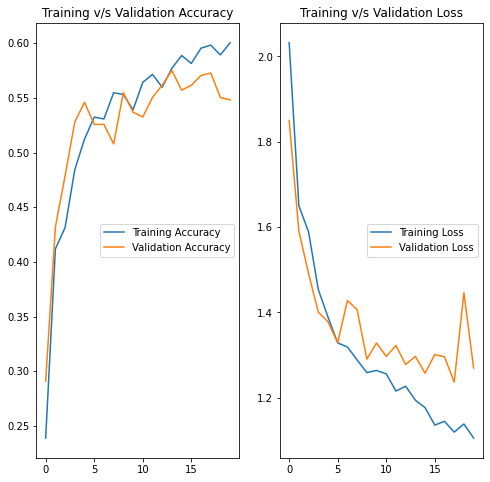

In [35]:
# Visualizing results where model includes augmentation and no dropouts.
train_acc = model_no_dropouts_results.history['accuracy']
val_acc = model_no_dropouts_results.history['val_accuracy']

train_loss = model_no_dropouts_results.history['loss']
val_loss = model_no_dropouts_results.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))

# Visualizing training and validation accuracy
plt.subplot(1,2,1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='center right')
plt.title('Training v/s Validation Accuracy')

# Visualizing training and validation loss
plt.subplot(1,2,2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='center right')
plt.title('Training v/s Validation Loss')

plt.show()

**Analysis** : It is evident from the above graph that in both cases i.e. including and without including dropouts the results after including augmentation show reduced difference between training and validation accuracy. In both cases, the model performance is almost same in terms of accuracy. This suggests that the model is not overfitting and is now more generalized than the previous one. Hence, after including data augmentation the model is now more generalizable.

### **Checking and fixing class imbalance(if any) for model training**

In [36]:
# Entire training dataset is divided into 32 batches. Each batch contains a set of 32 images and its corresponding 32 labels. Each batch is a tensor. It is difficult to iterate over a tensor and hence we need to convert to a numpy array and then iterate over it.
class_list = []
for images, labels in train_ds:
  labels_numpy = labels.numpy().astype("uint8")
  for label in labels_numpy:
    class_list.append(class_names[label])

In [37]:
len(class_list)

1792

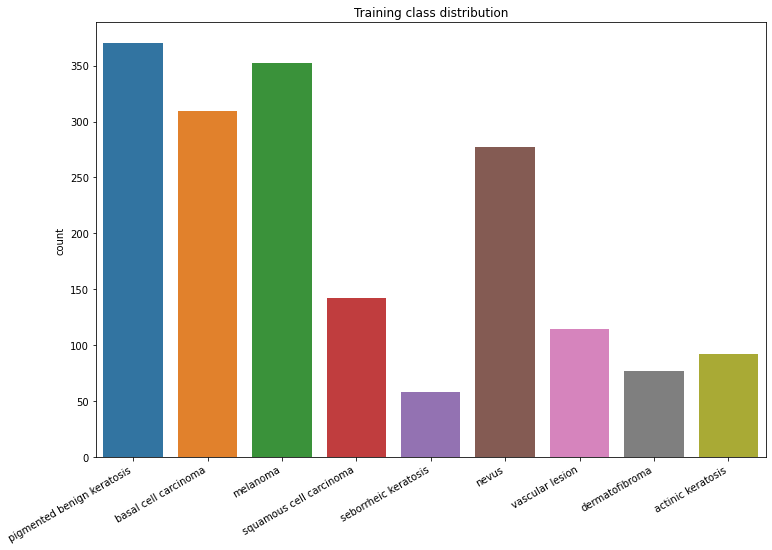

In [38]:
import seaborn as sns
plt.figure(figsize=(12,8))
ax = sns.countplot(x=class_list)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
plt.title("Training class distribution")
plt.show()

**Analysis** :
1. seborrheic keratosis has the least number of samples (50).
2. melanoma and pigmented benign keratosis dominate the data in terms of proportionate number of samples (>350).
3. There are clear signs of class imbalance in the training data set which needs to be treated and can be done using the Augmentor library.

A python package known as **Augmentor (https://augmentor.readthedocs.io/en/master/)** can be used to add more samples across all classes so that none of the classes have very few samples. This helps avoiding skewness in the model.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [39]:
!pip install Augmentor

In [40]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
  p = Augmentor.Pipeline(path_to_training_dataset+i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F188ACE2A90>: 100%|██████████| 500/500 [00:22<00:00, 22.35 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F188A492910>: 100%|██████████| 500/500 [00:23<00:00, 21.50 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F197C9C5350>: 100%|██████████| 500/500 [00:23<00:00, 21.44 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F188AD3DB90>: 100%|██████████| 500/500 [02:00<00:00,  4.14 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x7F188AD8CF50>: 100%|██████████| 500/500 [01:26<00:00,  5.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F190107AF10>: 100%|██████████| 500/500 [00:21<00:00, 22.90 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F190104B410>: 100%|██████████| 500/500 [00:49<00:00, 10.15 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F197CC58E50>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F197CBFC790>: 100%|██████████| 500/500 [00:20<00:00, 24.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
augmented_image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(augmented_image_count_train) # combined result for each of the 9 classes(500 samples for each)

4500


Adding the newly created/augmented images to the original training data.

In [42]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025825.jpg_ac7fe402-b594-4a17-8438-83aa31e45cc3.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028854.jpg_5ab171ca-304b-44a3-868f-cd04a09c22cd.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_35dc6758-1afe-4182-83dc-186eb07fe2a3.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_f431adbb-5131-4669-8c8c-09f79db77311.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_bde1d453-a141-41e6-b62d-b6ce749a5c82.jpg',
 '/content/Skin cancer ISIC The International

In [43]:
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [44]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict = dict(zip(path_list, lesion_list))

In [45]:
dataframe_dict_new

{'/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025825.jpg_ac7fe402-b594-4a17-8438-83aa31e45cc3.jpg': 'actinic keratosis',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028854.jpg_5ab171ca-304b-44a3-868f-cd04a09c22cd.jpg': 'actinic keratosis',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030133.jpg_35dc6758-1afe-4182-83dc-186eb07fe2a3.jpg': 'actinic keratosis',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_f431adbb-5131-4669-8c8c-09f79db77311.jpg': 'actinic keratosis',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030491.jpg_bde1

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

new_df = original_df.append(df2)

In [47]:
original_df['Label'].value_counts()

Train    2239
Name: Label, dtype: int64

In [48]:
original_df['Label'].value_counts()

Train    2239
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### **Train the model on the data created using Augmentor**

In [49]:
batch_size = 32
img_height = 180
img_width = 180

In [50]:
# Creating data directory which contains the orginal + augmented data
data_dir_train_augmented="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# Creating training dataset
train_ds_augmented = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_augmented,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [51]:
# Creating training dataset
val_ds_augmented = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_augmented,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only training data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [52]:
# Creating Sequential layers in CNN
model_augmented = Sequential([
            layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
            layers.Conv2D(16, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.1),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.1),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Dropout(0.1),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(len(class_names))
])

In [53]:
# Compiling the model
model_augmented.compile(optimizer='adam', 
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy'])

In [54]:
model_augmented.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

For model creation this time we shall include an early stopping criteria on accuracy with a patience of 5. 

**Early Stopping** will help stop the training process when a monitored metric(accuracy in this case) has stopped improving. So even if the number of epochs are high the training will stop automatically when the patience level(the continuous epochs on which the metric does not improve) is reached.

In [55]:
# Creating an Early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
# This callback will stop the training when there is no improvement in the loss for five consecutive epochs.
epochs = 30
model_augmented_history = model_augmented.fit(train_ds_augmented, validation_data=val_ds_augmented, epochs=epochs, callbacks=[callback])

Epoch 1/30
169/169 [==============================] - 51s 293ms/step - loss: 2.1389 - accuracy: 0.2116 - val_loss: 1.8124 - val_accuracy: 0.3460
Epoch 2/30
169/169 [==============================] - 31s 171ms/step - loss: 1.5688 - accuracy: 0.3960 - val_loss: 1.4665 - val_accuracy: 0.4722
Epoch 3/30
169/169 [==============================] - 30s 170ms/step - loss: 1.3703 - accuracy: 0.4891 - val_loss: 1.4019 - val_accuracy: 0.4959
Epoch 4/30
169/169 [==============================] - 30s 170ms/step - loss: 1.2390 - accuracy: 0.5367 - val_loss: 1.2541 - val_accuracy: 0.5457
Epoch 5/30
169/169 [==============================] - 29s 168ms/step - loss: 1.0681 - accuracy: 0.6063 - val_loss: 1.1602 - val_accuracy: 0.5494
Epoch 6/30
169/169 [==============================] - 30s 172ms/step - loss: 0.9196 - accuracy: 0.6608 - val_loss: 1.0331 - val_accuracy: 0.6177
Epoch 7/30
169/169 [==============================] - 30s 172ms/step - loss: 0.8062 - accuracy: 0.7059 - val_loss: 0.9205 - val_ac

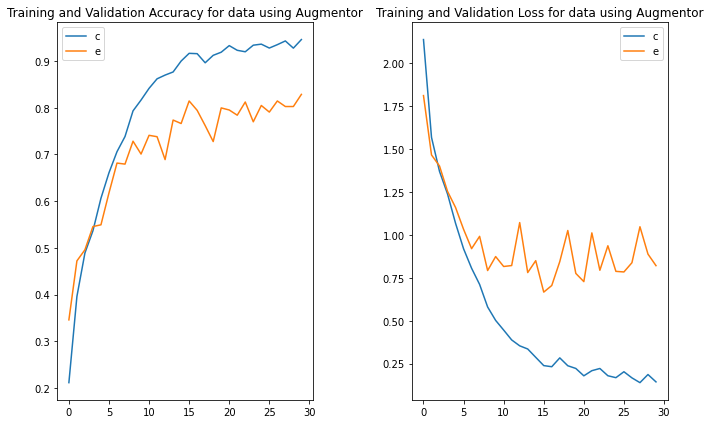

In [56]:
# Visualizing model results
acc = model_augmented_history.history['accuracy']
val_acc = model_augmented_history.history['val_accuracy']

loss = model_augmented_history.history['loss']
val_loss = model_augmented_history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Augmented Training Accuracy')
plt.plot(epochs_range, val_acc, label='Augmented Validation Accuracy')
plt.legend('center right')
plt.title('Training and Validation Accuracy for data using Augmentor')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Augmented Training Loss')
plt.plot(epochs_range, val_loss, label='Augmented Validation Loss')
plt.legend('center right')
plt.title('Training and Validation Loss for data using Augmentor')

plt.tight_layout()
plt.show()

**Analysis**:
 - Upon using the Augmentor library the accuracy in the network has drastically improved from close to 60% to 90% for training data and 53% to 83% for validation data.

### **Prediction for Image Classification**

In [57]:
# Prediction of Melanoma disease from the Test data set.
# Note: Data augmentation and dropout layers are inactive at inference time.

for images, labels in test_ds.take(1):
  for i in range(9):
    img_array = tf.keras.utils.img_to_array(images[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model_augmented.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
      "The current image {} most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[labels[i]], class_names[np.argmax(score)], 100 * np.max(score)))

The current image actinic keratosis most likely belongs to nevus with a 99.87 percent confidence.
The current image nevus most likely belongs to nevus with a 99.57 percent confidence.
The current image squamous cell carcinoma most likely belongs to pigmented benign keratosis with a 99.79 percent confidence.
The current image dermatofibroma most likely belongs to dermatofibroma with a 100.00 percent confidence.
The current image nevus most likely belongs to melanoma with a 85.72 percent confidence.
The current image basal cell carcinoma most likely belongs to basal cell carcinoma with a 71.62 percent confidence.
The current image melanoma most likely belongs to pigmented benign keratosis with a 100.00 percent confidence.
The current image nevus most likely belongs to nevus with a 95.92 percent confidence.
The current image nevus most likely belongs to nevus with a 100.00 percent confidence.
